# Обработка данных к ВПВ
В работе исследуются три зависимости:
1. Интенсивность поглощения от угла 
2. Величина g-фактора от угла
3. Ширина линии поглощения от угла

## Объявление необходимых библиотек

In [6]:
import pandas as pd 
from scipy.optimize import curve_fit 
import numpy as np
import matplotlib.pyplot as plt

import os

## Пересчет показаний приборов в необходимые величины

Главная подгоночная функция в нашей работе - это функция Лоренца, которая учитывает и дрейф в установке, создающий определенный наклон на графиках, и резонансный пик.

In [161]:
# Функция Лоренца
def lorentzian(x, u0, x0, k, a, b, d): 
    return u0 * (1 + k * x) * (
        1 - a / (1 + ((x - x0) / d) ** 2) + b * (x - x0) / (1 + ((x - x0) / d) ** 2))

def lornentzian_driftless(x, u0, x0, k, a, b, d):
    return u0 * (1 - a / (1 + ((x - x0) / d) ** 2) + b * (x - x0) / (1 + ((x - x0) / d) ** 2)) 

def drift_off(x_values, y_values, ampl, slope):
    result = np.empty(len(x_values))
    for i in range(len(y_values)):
        result[i] = y_values[i] / (1 + slope*x_values[i]) / ampl
    return result

В первую очередь избавимся от дрейфа в показаниях.

Отмечу, что дрейф обусловлен луной в казероге и его не должно быть (да уж, тяжела судьба физика-экспериментатора), именно поэтому мы и хотим его убрать.

['01 11GHz 270degr.dat', '02 11GHz 270degr.dat', '03 11GHz 000degr.dat', '04 11GHz 350degr.dat', '05 11GHz 340degr.dat', '06 11GHz 330degr.dat', '07 11GHz 320degr.dat', '08 11GHz 310degr.dat', '09 11GHz 300degr.dat', '10 11GHz 290degr.dat', '11 11GHz 280degr.dat', '12 11GHz 270degr.dat', '13 11GHz 260degr.dat', '14 11GHz 250degr.dat', '15 11GHz 240degr.dat', '16 11GHz 230degr.dat', '17 11GHz 230degr.dat', '18 11GHz 220degr.dat', '19 11GHz 210degr.dat', '20 11GHz 200degr.dat', '21 11GHz 010degr.dat', '22 9GHz 270degr copy.dat', '22 9GHz 270degr.dat', '23 14GHz 270degr.dat']
Fitted parameters:
u0 = 3344.8173, x0 = 2.1144e-02, k = -1.8998, a = 0.2447, b = 120.6029, d = 4.7178e-04
Файл 01 11GHz 270degr.dat успешно обработан и сохранён как /home/golenn/EPR/data_driftless/driftless 01 11GHz 270degr.dat
Fitted parameters:
u0 = 3380.3847, x0 = 2.1058e-02, k = 0.9072, a = 0.2542, b = -36.1634, d = 4.8124e-04
Файл 02 11GHz 270degr.dat успешно обработан и сохранён как /home/golenn/EPR/data_driftl

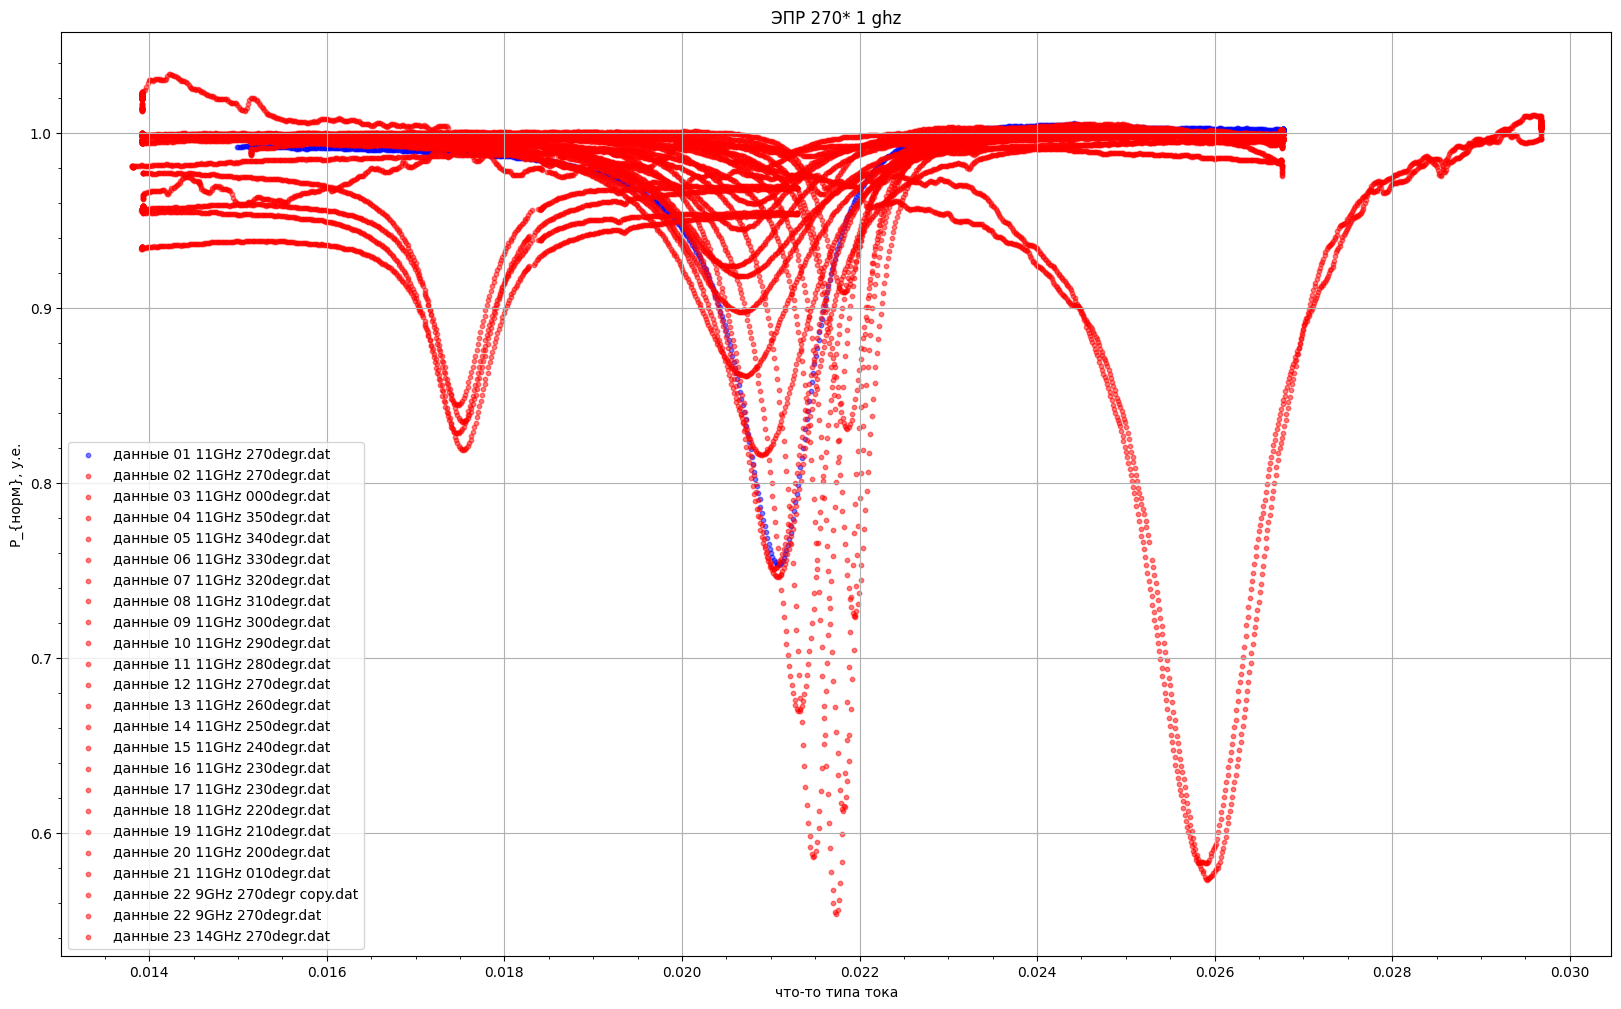

In [176]:
# Объявление путей директорий с файлами 
input_folder = '/home/golenn/EPR/data/'
output_folder = '/home/golenn/EPR/data_driftless/'
#os.makedirs(output_folder, exist_ok=True)

# min = 

plt.figure(figsize=(20, 12))
plt.title('ЭПР 270* 1 ghz')
plt.ylabel(r'P_{норм}, у.е.')
plt.xlabel(r'что-то типа тока')

my_color = ['blue', 'red']
flag = 0
files = os.listdir(input_folder)
files.sort()
print(files)
for file_name in files:
    input_file_path = os.path.join(input_folder, file_name)
    output_file_path = os.path.join(output_folder, f"driftless {file_name}")
    
    # Загрузка данных
    df = pd.read_csv(input_file_path, skiprows=3, sep='\t')
    df.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
    x_data = df["X_channel"].values
    y_data = df["Y_channel"].values

    # В наших данных нет пропущенных ячеек, поэтому лишний код на проверку этого не пишем
    
    try:
        # Начальные приближения параметров
        if '14' in file_name: # сильный разброс, поэтому лучше сразу отнормировать по максимуму
            y_data /= np.max(y_data)
            print('norm')
        
        u0_guess = (y_data[0] + y_data[len(y_data)-1])/2
        x0_guess = x_data[np.argmax(y_data)]
        initial_guess = [u0_guess, x0_guess, -1, 0.1, 0.1, 0.1]

        # Подбор параметров
        params, params_cov = curve_fit(lorentzian, x_data, y_data, p0=initial_guess)
        k = params[2]
        u0 = params[0]

        # Подгонка каждой точки к значению без дрейфа
        y_data = drift_off(x_data, y_data, params[0], params[2])

        print("Fitted parameters:")
        print(f"u0 = {params[0]:.4f}, x0 = {params[1]:.4e}, k = {params[2]:.4f}, "
            f"a = {params[3]:.4f}, b = {params[4]:.4f}, d = {params[5]:.4e}")
        
        # Генерация кривой для графика
        x_fit = np.linspace(min(x_data), max(x_data), 500)
        y_fit = lornentzian_driftless(x_fit, *params)

    except Exception:
        print('Exception raised')
        y_data = y_data / np.max(y_data)

    # Сохранение результата
    df.to_csv(output_file_path, sep=' ', index=False)
    print(f"Файл {file_name} успешно обработан и сохранён как {output_file_path}")

  
    # Построение графика
    clr = ''
    if flag == 0:
        clr = my_color[0]
        flag += 1
    else:
        clr = my_color[1]
    plt.scatter(x_data, y_data, color=clr, label=f'данные {file_name}', alpha=0.5, s=10)
    #plt.scatter(x_data[np.argmax(x_data):], y_data[np.argmax(x_data):], color='green', label='данные', alpha=0.6)
    #plt.plot(x_fit, y_fit, color='red', label='подгонка Лоренцом', linewidth=2)
    
    # Вывод параметров
    
    
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

    #plt.savefig(fname='EPR 9 GHz')


После того, как мы убрали дрейф, можем пересчитать снимаемые с приборов величины в те, что удобно интерпретировать с точки зрения теории.

**По оси X** - напряжение на датчике Холла, прикрепленном к полюсу магнита. Поле на полюсе отличается (в пределах 10%) от поля в центре, но они пропорциональны друг другу (линейность уравнений Максвелла). 

При помощи метки ДФПГ мы найдем коэффициент пересчёта между этими милливольтами и килогауссами/килоэрстедами.

**По оси Y** - напряженеи на детекторе, пропорциональное мощности сигнала, прошедшего через резонатор. Точнее - при помощи синхронного детектора  измеряем абсолютную амплитуду (фазу не учитываем) первой гармоники ни частоте амплитудной модуляции меандром с глубиной 100%. Частота модуляции - около 1 кГц. Создаётся внешним генератором меандра, синхронизованным с синхронным детектором и, для наглядности, с осциллографом.


## Визуализация для одного положения при разных частотах
Напишем функцию, подгоняющую данные по формуле и построим график

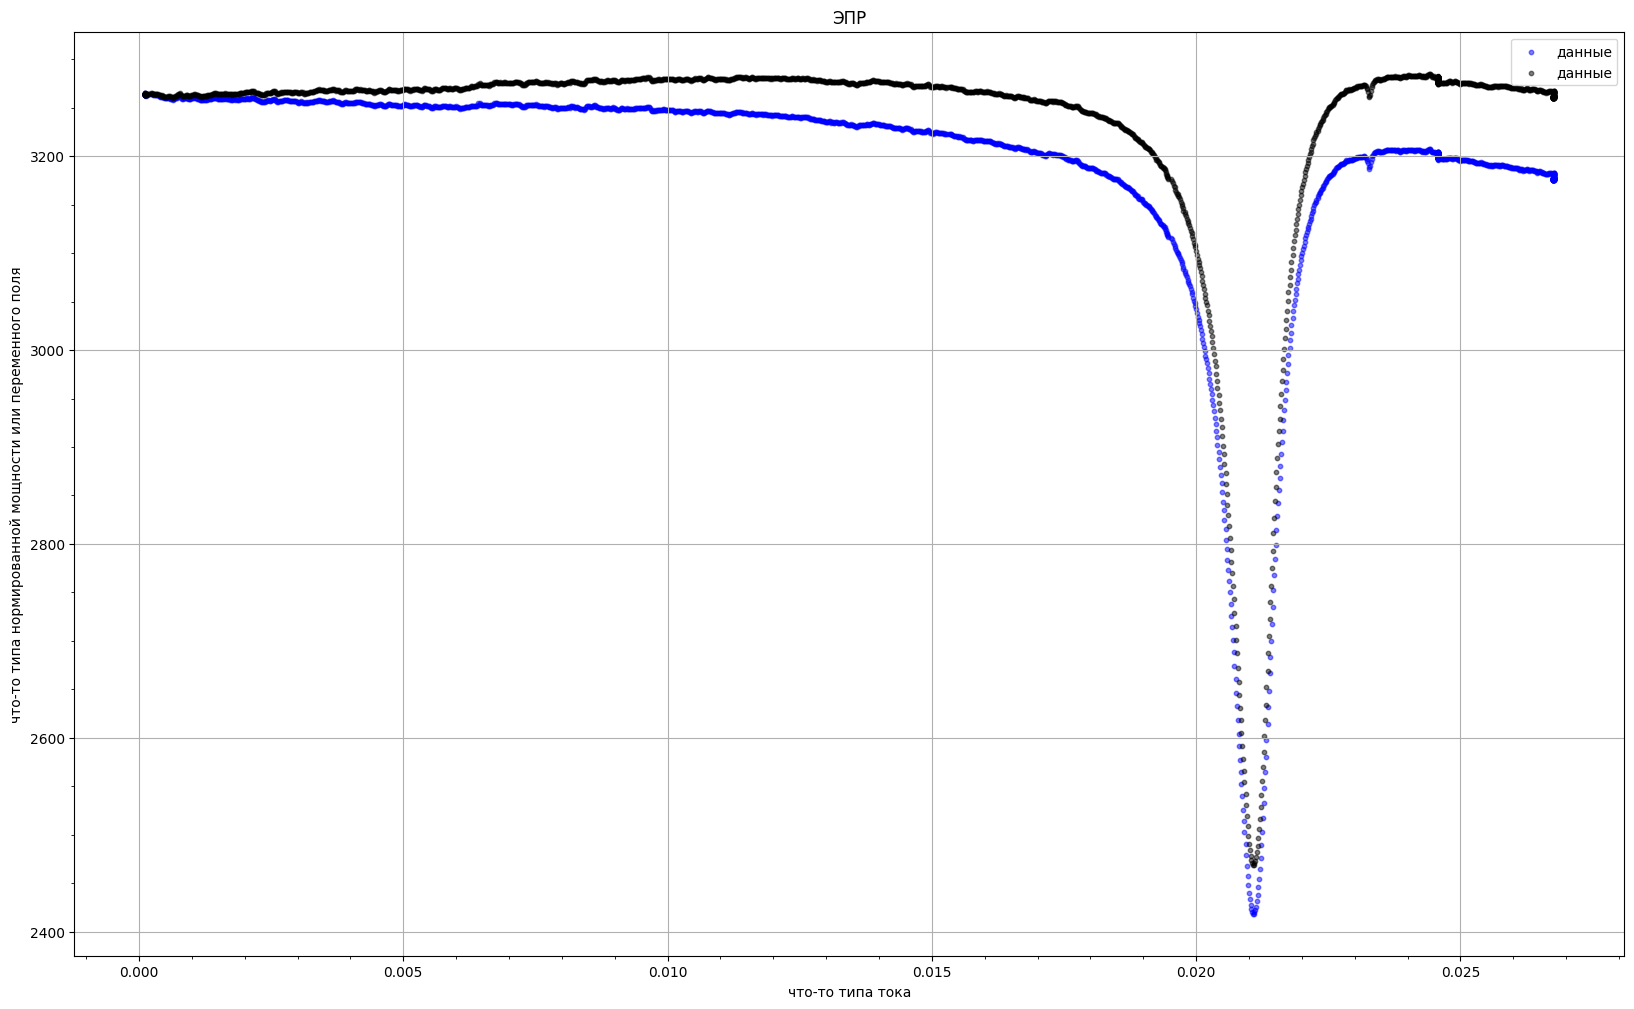

Fitted parameters:
u0 = 3277.8122, x0 = 2.1113e-02, k = -0.9696, a = 0.2477, b = 83.5220, d = -4.6680e-04


In [111]:
# Считывание данных из файла
filename = '/home/golenn/EPR/data/01 11GHz 270degr.dat'
data = pd.read_csv(filename, skiprows=3, sep='\t')
data.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
x_data = data["X_channel"].values
y_data = data["Y_channel"].values

# Нормировка по Y
#y_max = max(y_data)
#for i in range(len(y_data)):
#    y_data[i] = y_data[i] / y_max 

# Начальные приближения параметров
u0_guess =  4000
x0_guess = x_data[np.argmax(y_data)]
initial_guess = [u0_guess, x0_guess, -1, 0.1, 0.1, 0.1]

# Подбор параметров
#params1, params_cov1 = curve_fit(lorentzian, x_data[300:500], y_data[300:500], p0=initial_guess)
params, params_cov = curve_fit(lorentzian, x_data, y_data, p0=initial_guess)

y = drift_off(x_data, y_data, params[2])

# Генерация кривой для графика
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = lornentzian_driftless(x_fit, *params)
#y_fit_1 = lorentzian(x_fit, *params1)

# Построение графика
plt.figure(figsize=(20, 12))
plt.scatter(x_data, y_data, color='blue', label='данные', alpha=0.5, s=10)
plt.scatter(x_data, y, color='black', label='данные', alpha=0.5, s=10)

#plt.scatter(x_data[np.argmax(x_data):], y_data[np.argmax(x_data):], color='green', label='данные', alpha=0.6)
#plt.plot(x_fit, y_fit, color='green', label='подгонка Лоренцом по всем данным', linewidth=2)
#plt.plot(x_fit, y_fit_1, color='green', label='подгонка Лоренцом по пику', linewidth=2)

plt.title('ЭПР')
plt.ylabel('что-то типа нормированной мощности или переменного поля')
plt.xlabel('что-то типа тока')
plt.legend()
plt.grid()
plt.minorticks_on()

#plt.savefig(fname='EPR 9 GHz')
plt.show()
# Вывод параметров
print("Fitted parameters:")
print(f"u0 = {params[0]:.4f}, x0 = {params[1]:.4e}, k = {params[2]:.4f}, "
      f"a = {params[3]:.4f}, b = {params[4]:.4f}, d = {params[5]:.4e}")


отдельный просчет для 9 ГГц, тк разный дрейф при увелечении и уменьшении тока 

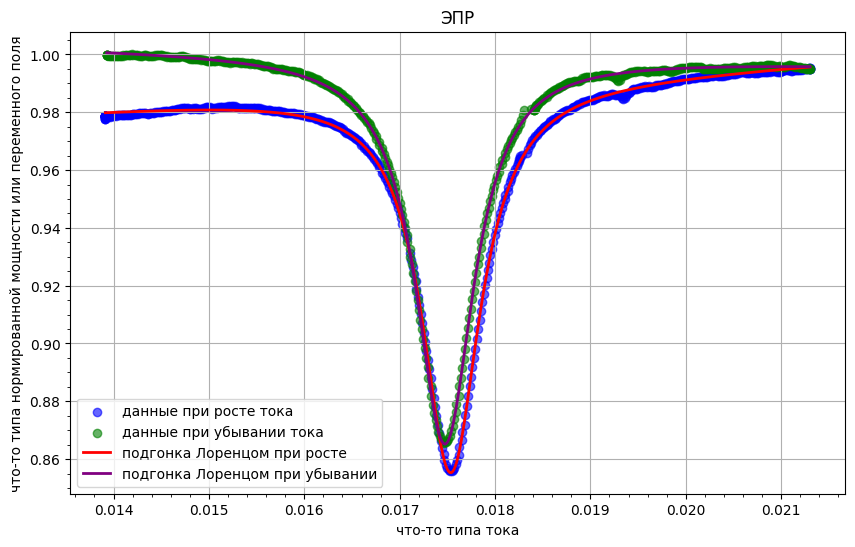

Интерполяционные коэффициенты для возрастания тока:
u0 = 0.9514, x0 = 1.7535e-02, k = 2.2508, a = 0.1352, b = -1.0217, d = -3.6888e-04
Интерполяционные коэффициенты для убывания тока:
u0 = 1.0126, x0 = 1.7477e-02, k = -0.7347, a = 0.1345, b = 6.0521, d = 3.6956e-04


In [ ]:
# Функция Лоренца
def lorentzian(x, u0, x0, k, a, b, d): # u0 убрал из формулы, тк в итоге работаем с нормированными величинами, но оставим её здесь на всякий случай
    return u0*(1 + k * x) * (
        1 - a / (1 + ((x - x0) / d) ** 2) + b * (x - x0) / (1 + ((x - x0) / d) ** 2)
    )

# Считывание данных из файла
filename = '/home/golenn/EPR/data/22 9GHz 270degr.dat'
data = pd.read_csv(filename, skiprows=3, sep='\t')
data.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
x_data = data["X_channel"].values
y_data = data["Y_channel"].values

# Нормировка по Y для возрастания и убывания тока
x_idx_max = np.argmax(x_data)

y_max = max(y_data)
for i in range(len(y_data)):
    y_data[i] = y_data[i] / y_max 
red
x0_guess_1 = x1_data[np.argmax(y1_data)]
x0_guess_2 = x2_data[np.argmax(y2_data)]
initial_guess_1 = [u0_guess_1, x0_guess_1, 1, 0.1, 0.1, 0.1]
initial_guess_2 = [u0_guess_2, x0_guess_2, -2, 0.1, 0.1, 0.1]

# Подбор параметров для случаев возрастания и убывания тока
params1, params_cov1 = curve_fit(lorentzian, x1_data, y1_data, p0=initial_guess_1)
params2, params_cov2 = curve_fit(lorentzian, x2_data, y2_data, p0=initial_guess_2)

# Генерация кривых для графика
x_fit1 = np.linspace(min(x1_data), max(x1_data), 500)
y_fit1 = lorentzian(x_fit1, *params1)
x_fit2 = np.linspace(min(x2_data), max(x2_data), 500)
y_fit2 = lorentzian(x_fit2, *params2)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(x1_data, y1_data, color='blue', label='данные при росте тока', alpha=0.6)
plt.scatter(x2_data, y2_data, color='green', label='данные при убывании тока', alpha=0.6)
plt.plot(x_fit1, y_fit1, color='red', label='подгонка Лоренцом при росте', linewidth=2)
plt.plot(x_fit2, y_fit2, color='purple', label='подгонка Лоренцом при убывании', linewidth=2)
plt.title('ЭПР')
plt.ylabel('что-то типа нормированной мощности или переменного поля')
plt.xlabel('что-то типа тока')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.grid('minor', 'both')
plt.savefig(fname='EPR 9 GHz')
plt.show()
# Вывод параметров
print("Интерполяционные коэффициенты для возрастания тока:")
print(f"u0 = {params1[0]:.4f}, x0 = {params1[1]:.4e}, k = {params1[2]:.4f}, "
      f"a = {params1[3]:.4f}, b = {params1[4]:.4f}, d = {params1[5]:.4e}")

print("Интерполяционные коэффициенты для убывания тока:")
print(f"u0 = {params2[0]:.4f}, x0 = {params2[1]:.4e}, k = {params2[2]:.4f}, "
      f"a = {params2[3]:.4f}, b = {params2[4]:.4f}, d = {params2[5]:.4e}")


отдельный просчет для 14 ГГц, тк разный дрейф при увелечении и уменьшении тока 

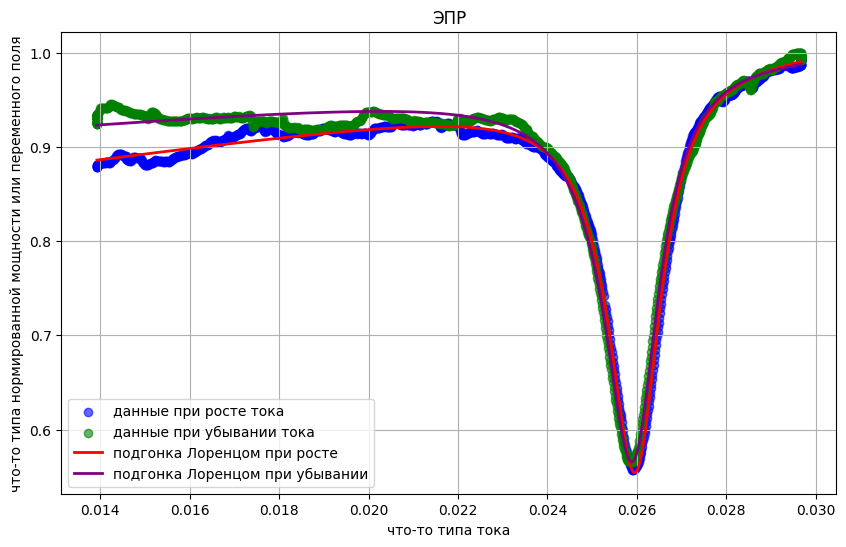

Интерполяционные коэффициенты для возрастания тока:
u0 = 0.7989, x0 = 2.6008e-02, k = 8.2462, a = 0.4262, b = 89.1212, d = 7.0821e-04
Интерполяционные коэффициенты для убывания тока:
u0 = 0.8751, x0 = 2.5954e-02, k = 4.4056, a = 0.4168, b = 97.9485, d = -7.4283e-04


In [5]:
# Функция Лоренца
def lorentzian(x, u0, x0, k, a, b, d): # u0 убрал из формулы, тк в итоге работаем с нормированными величинами, но оставим её здесь на всякий случай
    return u0*(1 + k * x) * (
        1 - a / (1 + ((x - x0) / d) ** 2) + b * (x - x0) / (1 + ((x - x0) / d) ** 2)
    )

# Считывание данных из файла
filename = '/home/golenn/EPR/data/23 14GHz 270degr.dat'
data = pd.read_csv(filename, skiprows=3, sep='\t')
data.columns = ["X_channel", "Y_channel", "II_channel", "timestamp"]
x_data = data["X_channel"].values
y_data = data["Y_channel"].values

# Нормировка по Y для возрастания и убывания тока
x_idx_max = np.argmax(x_data)

y_max = max(y_data)
for i in range(len(y_data)):
    y_data[i] = y_data[i] / y_max 

y1_data = y_data[:x_idx_max]
x1_data = x_data[:x_idx_max]
y2_data = y_data[x_idx_max:]
x2_data = x_data[x_idx_max:]

# Начальные приближения параметров для случаев возрастания и убывания тока
u0_guess_1, u0_guess_2 = 1, 0.98
x0_guess_1 = x1_data[np.argmax(y1_data)]
x0_guess_2 = x2_data[np.argmax(y2_data)]
initial_guess_1 = [u0_guess_1, x0_guess_1, 1, 0.1, 0.1, 0.1]
initial_guess_2 = [u0_guess_2, x0_guess_2, -2, 0.1, 0.1, 0.1]

# Подбор параметров для случаев возрастания и убывания тока
params1, params_cov1 = curve_fit(lorentzian, x1_data, y1_data, p0=initial_guess_1)
params2, params_cov2 = curve_fit(lorentzian, x2_data, y2_data, p0=initial_guess_2)

# Генерация кривых для графика
x_fit1 = np.linspace(min(x1_data), max(x1_data), 500)
y_fit1 = lorentzian(x_fit1, *params1)
x_fit2 = np.linspace(min(x2_data), max(x2_data), 500)
y_fit2 = lorentzian(x_fit2, *params2)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(x1_data, y1_data, color='blue', label='данные при росте тока', alpha=0.6)
plt.scatter(x2_data, y2_data, color='green', label='данные при убывании тока', alpha=0.6)
plt.plot(x_fit1, y_fit1, color='red', label='подгонка Лоренцом при росте', linewidth=2)
plt.plot(x_fit2, y_fit2, color='purple', label='подгонка Лоренцом при убывании', linewidth=2)
plt.title('ЭПР')
plt.ylabel('что-то типа нормированной мощности или переменного поля')
plt.xlabel('что-то типа тока')
plt.legend()
plt.grid()
plt.savefig(fname='EPR 14 GHz')
plt.show()
# Вывод параметров
print("Интерполяционные коэффициенты для возрастания тока:")
print(f"u0 = {params1[0]:.4f}, x0 = {params1[1]:.4e}, k = {params1[2]:.4f}, "
      f"a = {params1[3]:.4f}, b = {params1[4]:.4f}, d = {params1[5]:.4e}")

print("Интерполяционные коэффициенты для убывания тока:")
print(f"u0 = {params2[0]:.4f}, x0 = {params2[1]:.4e}, k = {params2[2]:.4f}, "
      f"a = {params2[3]:.4f}, b = {params2[4]:.4f}, d = {params2[5]:.4e}")


## Сбор данных по всем опытам на 11.43 ГГц
